# **Scratchpad merge**

Tout ce qui a été essayé avant d'arriver à la version finale.

# Dans `installments_payments`

## Préparons les données

In [ ]:
from home_credit.load import get_installments_payments
from pepper.plots import lin_log_tetra_histplot
gregorian_month = 365.2425 / 12
data = get_installments_payments().copy()
data.DAYS_INSTALMENT = -data.DAYS_INSTALMENT
data.DAYS_ENTRY_PAYMENT = -data.DAYS_ENTRY_PAYMENT
data["diff_DAYS"] = data.DAYS_INSTALMENT - data.DAYS_ENTRY_PAYMENT
data["diff_AMT"] = data.AMT_PAYMENT - data.AMT_INSTALMENT
data["MONTHS_BALANCE"] = (data.DAYS_INSTALMENT // gregorian_month).astype(int)

load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\installments_payments.pqt


In [ ]:
display(data)
var_names = list(data.columns[3:])
display(var_names)

RAW_INSTALLMENTS_PAYMENTS,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,diff_DAYS,diff_AMT,MONTHS_BALANCE
0,1054186,161674,1.0,6,1180.0,1187.0,6948.360,6948.360,-7.0,0.000,38
1,1330831,151639,0.0,34,2156.0,2156.0,1716.525,1716.525,0.0,0.000,70
2,2085231,193053,2.0,1,63.0,63.0,25425.000,25425.000,0.0,0.000,2
3,2452527,199697,1.0,3,2418.0,2426.0,24350.130,24350.130,-8.0,0.000,79
4,2714724,167756,1.0,2,1383.0,1366.0,2165.040,2160.585,17.0,-4.455,45
...,...,...,...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,1624.0,NaN,67.500,NaN,NaN,NaN,53
13605397,1310347,414406,0.0,47,1539.0,NaN,67.500,NaN,NaN,NaN,50
13605398,1308766,402199,0.0,43,7.0,NaN,43737.435,NaN,NaN,NaN,0
13605399,1062206,409297,0.0,43,1986.0,NaN,67.500,NaN,NaN,NaN,65


['NUM_INSTALMENT_NUMBER',
 'DAYS_INSTALMENT',
 'DAYS_ENTRY_PAYMENT',
 'AMT_INSTALMENT',
 'AMT_PAYMENT',
 'diff_DAYS',
 'diff_AMT',
 'MONTHS_BALANCE']

## Pré-pivotement

Contrairement aux tables de balance, si l'on cherche à pivoter maintenant, cela va engendrer une `ValueError: Index contains duplicate entries, cannot reshape`.

Avant de choisir de passer en force brute (cf. les injonctions de l'époque) avec un `pivot_table` aggrégateur, la finesse nous invite à comprendre la nature des couples (["SK_ID_CURR", "SK_ID_PREV"], "MONTHS_BALANCE") à occurrences multiples.

### Nature des doublons

In [ ]:
piv_idx_cols = data[["SK_ID_CURR", "SK_ID_PREV", "MONTHS_BALANCE"]]
display(piv_idx_cols)

RAW_INSTALLMENTS_PAYMENTS,SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE
0,161674,1054186,38
1,151639,1330831,70
2,193053,2085231,2
3,199697,2452527,79
4,167756,2714724,45
...,...,...,...
13605396,428057,2186857,53
13605397,414406,1310347,50
13605398,402199,1308766,0
13605399,409297,1062206,65


Sur 13.6 millions de lignes, 3.9 sont des doublons, soit près d'un tiers.

In [ ]:
duplicated = piv_idx_cols[piv_idx_cols.duplicated(keep=False)]
display(duplicated)
#display(piv_idx_cols[duplicated])

RAW_INSTALLMENTS_PAYMENTS,SK_ID_CURR,SK_ID_PREV,MONTHS_BALANCE
4,167756,2714724,45
8,112102,2723183,6
12,147645,1570206,25
17,197687,1410565,34
27,162903,1991673,83
...,...,...,...
13605347,444977,2784672,5
13605371,415656,1860833,5
13605372,415656,1860833,5
13605374,405841,1659443,63


On constate que le phénomène de doublonnage se répète, pour un prêt précédent donné, sur plusieurs mois :

In [ ]:
dupl_counts = pd.DataFrame(duplicated.groupby(
    by=["SK_ID_CURR", "SK_ID_PREV", "MONTHS_BALANCE"]
).size().rename("COUNT")).sort_values(by="COUNT", ascending=False)
display(dupl_counts)

COUNT
SK_ID_CURR SK_ID_PREV MONTHS_BALANCE       
430301     1610767    3                  23
                      0                  21
                      4                  20
                      5                  20
                      6                  19
...                                     ...
228953     1623332    1                   2
                      0                   2
228952     1459357    12                  2
228949     2450922    7                   2
456255     2631384    24                  2

[1796064 rows x 1 columns]

Zoomons sur un cas :

In [ ]:
max_case = data[
    (data.SK_ID_CURR == 430301)
    & (data.SK_ID_PREV == 1610767)
    & (data.MONTHS_BALANCE == 3)
].copy().sort_values(by="DAYS_INSTALMENT")
max_case.loc["TOTAL"] = max_case.sum(axis=0)

display(max_case)

RAW_INSTALLMENTS_PAYMENTS,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,diff_DAYS,diff_AMT,MONTHS_BALANCE
13381552,1610767.0,430301.0,0.0,122.0,92.0,92.0,4500.000,4500.000,0.0,0.0,3.0
13046745,1610767.0,430301.0,0.0,121.0,93.0,93.0,10827.405,10827.405,0.0,0.0,3.0
11982778,1610767.0,430301.0,0.0,119.0,95.0,95.0,22994.145,22994.145,0.0,0.0,3.0
13401647,1610767.0,430301.0,0.0,118.0,96.0,96.0,215.280,215.280,0.0,0.0,3.0
13029625,1610767.0,430301.0,0.0,117.0,99.0,99.0,342.900,342.900,0.0,0.0,3.0
12014494,1610767.0,430301.0,0.0,116.0,100.0,100.0,1143.540,1143.540,0.0,0.0,3.0
12567893,1610767.0,430301.0,0.0,99.0,102.0,121.0,12285.045,12285.045,-19.0,0.0,3.0
13424080,1610767.0,430301.0,0.0,115.0,102.0,102.0,1104.705,1104.705,0.0,0.0,3.0
12622603,1610767.0,430301.0,0.0,114.0,104.0,104.0,27450.000,27450.000,0.0,0.0,3.0
12459572,1610767.0,430301.0,0.0,113.0,106.0,106.0,72229.365,72229.365,0.0,0.0,3.0


Observons les paiements de ce client sur ce prêt dans le temps : il s'agit d'un client qui a payé en moyenne 5580 par jour pendant 410 jours. La multiplication des échéance par période mensuelle est la conséquence de cette densité.

RAW_INSTALLMENTS_PAYMENTS,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,diff_DAYS,diff_AMT,MONTHS_BALANCE
11527722,1610767,430301,0.0,20,277.0,277.0,2700.00,2700.00,0.0,0.0,9
11527723,1610767,430301,0.0,134,67.0,67.0,22050.00,22050.00,0.0,0.0,2
11534614,1610767,430301,0.0,106,114.0,114.0,31500.00,31500.00,0.0,0.0,3
11535466,1610767,430301,0.0,30,242.0,242.0,22500.00,22500.00,0.0,0.0,7
11539778,1610767,430301,0.0,17,302.0,302.0,34425.00,34425.00,0.0,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...
13532199,1610767,430301,0.0,85,140.0,140.0,14850.00,14850.00,0.0,0.0,4
13552300,1610767,430301,0.0,46,206.0,206.0,18000.00,18000.00,0.0,0.0,6
13571225,1610767,430301,0.0,47,204.0,204.0,25200.00,25200.00,0.0,0.0,6
13574855,1610767,430301,0.0,63,177.0,177.0,31950.00,31950.00,0.0,0.0,5


mean_day payt: 5581.500623471882


RAW_INSTALLMENTS_PAYMENTS,AMT_PAYMENT,EWM
DAYS_ENTRY_PAYMENT,,
1.0,562.500,562.500000
14.0,12.555,273.055263
19.0,1350.000,670.451845
27.0,9000.000,3092.536217
36.0,11250.000,5084.542220
...,...,...
402.0,15750.000,8443.981951
403.0,19111.500,9510.733802
406.0,25380.000,11097.660483


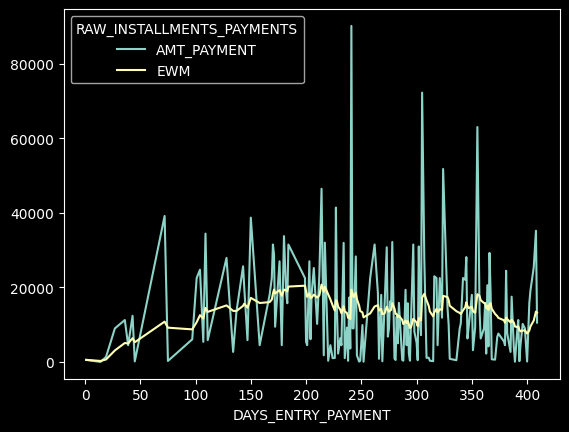

In [ ]:
import matplotlib.pyplot as plt
client_430301_1610767 = data[(data.SK_ID_CURR == 430301) & (data.SK_ID_PREV == 1610767)]
display(client_430301_1610767)
client_430301_1610767_day_payments = (
    client_430301_1610767
    .groupby("DAYS_ENTRY_PAYMENT")
    .agg({"AMT_PAYMENT": "sum"})
).reset_index()
client_430301_1610767_day_payments.DAYS_ENTRY_PAYMENT = 411 - client_430301_1610767_day_payments.DAYS_ENTRY_PAYMENT
client_430301_1610767_day_payments.sort_values(by="DAYS_ENTRY_PAYMENT", inplace=True)
client_430301_1610767_day_payments.set_index("DAYS_ENTRY_PAYMENT", drop=True, inplace=True)
# client_430301_1610767_day_payments["CUMSUM"] = \
#    client_430301_1610767_day_payments.AMT_PAYMENT.cumsum()
client_430301_1610767_day_payments["EWM"] = \
    client_430301_1610767_day_payments.AMT_PAYMENT.ewm(alpha=.1).mean()

print("mean_day payt:", client_430301_1610767_day_payments.AMT_PAYMENT.sum() / 409)
display(client_430301_1610767_day_payments)
client_430301_1610767_day_payments.plot()
plt.show()

### Dédoublonnement

Il s'agit de choisir une stratégie d'agrégation sur la base de ce que nous avons observé.

Nous allons finalement utiliser `pivot_table` qui permet à la fois de pivoter et agréger, mais pour la raison que c'est la fonction la plus adaptée à notre problème.

Nous allons agréger les données de la manière suivante :
* `NUM_INSTALMENT_VERSION` et `NUM_INSTALMENT_NUMBER` : il ne sont ici qu'informatifs, et intégralement restitués dans l'autre table pivotée : le maximum sera suffisant (dernière version, dernier numéro d'échéance)
* `DAYS_INSTALMENT`, `DAYS_ENTRY_PAYMENT` : on peut imaginer le dernier jour, ou le jour médian, sachant que la granularité importante dans notre pivot est le mois. Nous choisissons la médiane
* `AMT_INSTALMENT`, `AMT_PAYMENT` et `diff_AMT` : la somme, évidemment.
*  `diff_AMT` dépend du choix fait sur `DAYS_INSTALMENT`, `DAYS_ENTRY_PAYMENT`. Pour faire simple, il faudrait le recalculer sur la base de leur synthèse.

Comment ? Très simplement en ne calculant les variables dérivées autres que `MONTHS_BALANCE` qu'après la synthèse.

#### Préparation des données

Nous profitons de cette préparation pour faire sauter la transformation des durées négatives DAYS (cela prend du temps de calcul alors que ce n'est qu'un problème de confort de lecture). En outre, les variables dérivées, les distances entre deux dates négatives nous ramène dans un univers de positifs.

En revanche, `MONTHS_BALANCE` reste bien normalisé positif (avec 0 le plus récent et avec $y > x \equiv y \text{ plus ancien que } x$).

In [ ]:
from home_credit.load import get_installments_payments
from pepper.plots import lin_log_tetra_histplot
gregorian_month = 365.2425 / 12
data = get_installments_payments().copy()
# data.DAYS_INSTALMENT = -data.DAYS_INSTALMENT
# data.DAYS_ENTRY_PAYMENT = -data.DAYS_ENTRY_PAYMENT
#data["diff_DAYS"] = data.DAYS_INSTALMENT - data.DAYS_ENTRY_PAYMENT
#data["diff_AMT"] = data.AMT_PAYMENT - data.AMT_INSTALMENT
data["MONTHS_BALANCE"] = (-data.DAYS_INSTALMENT // gregorian_month).astype(int)
data.insert(0, "n_AGG", 1)

load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\installments_payments.pqt


In [ ]:
display(data)

RAW_INSTALLMENTS_PAYMENTS,n_AGG,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,MONTHS_BALANCE
0,1,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360,38
1,1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525,70
2,1,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000,2
3,1,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130,79
4,1,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585,45
...,...,...,...,...,...,...,...,...,...,...
13605396,1,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN,53
13605397,1,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN,50
13605398,1,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN,0
13605399,1,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN,65


Groupement et synthèse, qui nous fait tomber de $13\,605\,401$ à $11\,471\,325$ lignes.

Par anticipation sur une décision de la *feature engineering* team, nous préservons l'information du nombre de lignes agrégées en la variable `n_AGG`.

19 secondes, mais un pic de pression sur la mémoire.

In [ ]:
synth = data.groupby(by=["SK_ID_PREV", "SK_ID_CURR", "MONTHS_BALANCE"]).agg({
    "n_AGG": "size",
    "NUM_INSTALMENT_VERSION": "max",
    "NUM_INSTALMENT_NUMBER": "max",
    "DAYS_INSTALMENT": "median",
    "DAYS_ENTRY_PAYMENT": "median",
    "AMT_INSTALMENT": "sum",
    "AMT_PAYMENT": "sum"
})

In [ ]:
display(synth)

Sortie de `MONTHS_BALANCE` de l'index pour pouvoir le pivoter en colonnes.

In [ ]:
synth.reset_index(level=2, inplace=True)
display(synth)

RAW_INSTALLMENTS_PAYMENTS  MONTHS_BALANCE  n_AGG  NUM_INSTALMENT_VERSION   
SK_ID_PREV SK_ID_CURR                                                      
1000001    158271                       7      1                     2.0  \
           158271                       8      1                     1.0   
1000002    101962                      49      1                     2.0   
           101962                      50      1                     1.0   
           101962                      51      1                     1.0   
...                                   ...    ...                     ...   
2843499    314148                      35      1                     1.0   
           314148                      36      1                     1.0   
           314148                      37      1                     1.0   
           314148                      38      1                     1.0   
           314148                      39      1                     1.0   

RAW_INSTALLMENTS_PAYMENTS  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT   
SK_ID_PREV SK_ID_CURR                                               
1000001    158271                              2           -238.0  \
           158271                              1           -268.0   
1000002    101962                              4          -1510.0   
           101962                              3          -1540.0   
           101962                              2          -1570.0   
...                                          ...              ...   
2843499    314148                              5          -1083.0   
           314148                              4          -1113.0   
           314148                              3          -1143.0   
           314148                              2          -1173.0   
           314148                              1          -1203.0   

RAW_INSTALLMENTS_PAYMENTS  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
SK_ID_PREV SK_ID_CURR                                                       
1000001    158271                      -244.0       62039.115    62039.115  
           158271                      -294.0        6404.310     6404.310  
1000002    101962                     -1554.0       18443.565    18443.565  
           101962                     -1559.0        6264.000     6264.000  
           101962                     -1575.0        6264.000     6264.000  
...                                       ...             ...          ...  
2843499    314148                     -1109.0       16074.000    16074.000  
           314148                     -1138.0       16074.000    16074.000  
           314148                     -1172.0       16074.000    16074.000  
           314148                     -1201.0       16074.000    16074.000  
           314148                     -1220.0       16074.000    16074.000  

[11471325 rows x 8 columns]

## Pivotement

28 secondes, mais de l'équilibrisme avec la mémoire.

Il faut libérer un peu de mémoire pour avancer, libérons `data` dont nous n'avons plus besoin pour le moment.

In [ ]:
import gc
del data
_ = gc.collect()

In [ ]:
pivoted = synth.pivot(
    #index=["SK_ID_CURR", "SK_ID_PREV"],
    columns="MONTHS_BALANCE",
    #values=var_names
)
display(pivoted)

RAW_INSTALLMENTS_PAYMENTS n_AGG                                                
MONTHS_BALANCE               0    1    2    3    4    5    6    7    8    9    
SK_ID_PREV SK_ID_CURR                                                          
1000001    158271           NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  NaN  \
1000002    101962           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1000003    252457           NaN  1.0  1.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN   
1000004    260094           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1000005    176456           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2843495    260963           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0   
2843496    425374           1.0  1.0  2.0  1.0  2.0  2.0  3.0  3.0  2.0  3.0   
2843497    451578           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2843498    393881           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2843499    314148           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

RAW_INSTALLMENTS_PAYMENTS  ... AMT_PAYMENT                                      
MONTHS_BALANCE             ...          87  88  89  90  91  92  93  94  95  96  
SK_ID_PREV SK_ID_CURR      ...                                                  
1000001    158271          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1000002    101962          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1000003    252457          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1000004    260094          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1000005    176456          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
...                        ...         ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2843495    260963          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2843496    425374          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2843497    451578          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2843498    393881          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2843499    314148          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[997752 rows x 679 columns]

Tri de l'index : 14 s

In [ ]:
pivoted.sort_index(inplace=True)
display(pivoted)

RAW_INSTALLMENTS_PAYMENTS n_AGG                                                
MONTHS_BALANCE               0    1    2    3    4    5    6    7    8    9    
SK_ID_PREV SK_ID_CURR                                                          
1000001    158271           NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  NaN  \
1000002    101962           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1000003    252457           NaN  1.0  1.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN   
1000004    260094           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1000005    176456           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2843495    260963           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0   
2843496    425374           1.0  1.0  2.0  1.0  2.0  2.0  3.0  3.0  2.0  3.0   
2843497    451578           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2843498    393881           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2843499    314148           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

RAW_INSTALLMENTS_PAYMENTS  ... AMT_PAYMENT                                      
MONTHS_BALANCE             ...          87  88  89  90  91  92  93  94  95  96  
SK_ID_PREV SK_ID_CURR      ...                                                  
1000001    158271          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1000002    101962          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1000003    252457          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1000004    260094          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1000005    176456          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
...                        ...         ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2843495    260963          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2843496    425374          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2843497    451578          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2843498    393881          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2843499    314148          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[997752 rows x 679 columns]

Subindex, pour distinguer les solos des multis : .3 s

$339\,587$ solos.

In [ ]:
from pepper.pd_utils import subindex
import pandas as pd
sk_id_curr = pivoted.index.get_level_values(1).to_series()
subidx = subindex(sk_id_curr)
subidx.drop(columns=["SK_ID_CURR"], inplace=True)
display(pd.DataFrame(subidx.value_counts()).T.astype(int))

subindex,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
count,339587,244945,162190,101579,61942,36600,21362,12365,7166,4136,...,111,68,39,19,10,5,4,3,1,1


,count,mean,std,min,25%,50%,75%,max
subindex,997752.0,2.685148,1.961496,1.0,1.0,2.0,4.0,26.0


C:\Users\franc\Projects\pepper_credit_scoring_tool\modules\home_credit\plots.py:94: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  bins = min(int(1 + s.max() - s.min()), max_bins)


save_and_show_savefig(C:\Users\franc\Projects\pepper_credit_scoring_tool\img/dataxplor/linlog_tetra_hist_installments_paymentssk_id_curr_counts_histogram_2023_04_23_11_54_35_855336.png)


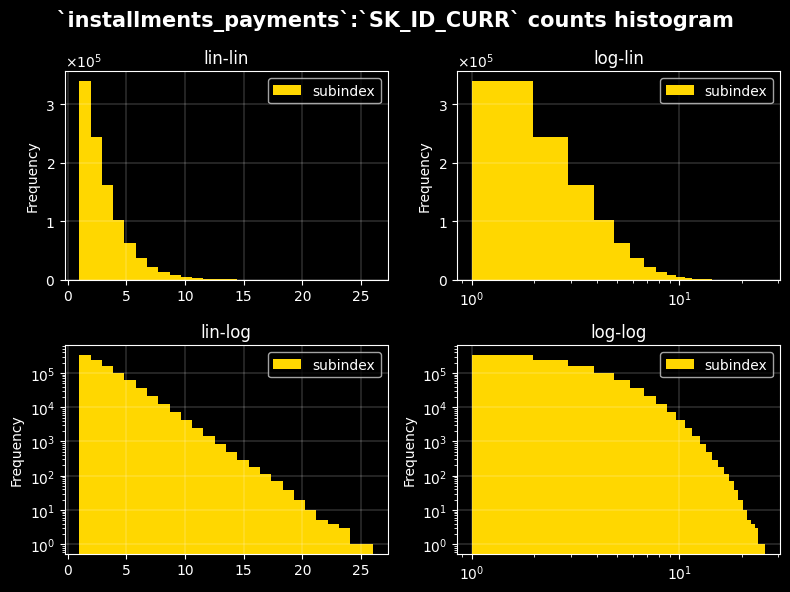

In [ ]:
from pepper.plots import lin_log_tetra_histplot
import pandas as pd
sk_id_counts = subidx + 1
display(pd.DataFrame(sk_id_counts.describe()).T.astype(int))
lin_log_tetra_histplot(
    sk_id_counts,
    title="`installments_payments`:`SK_ID_CURR` counts histogram"
)

Sépération : 51 s + 10 s, pression sur la mémoire

In [ ]:
single_prev_idx = subidx[subidx.subindex == 0]
single_prev_mask = sk_id_curr.isin(single_prev_idx.index).to_numpy()
single_prev_pivoted = pivoted[single_prev_mask]
display(single_prev_pivoted)

RAW_INSTALLMENTS_PAYMENTS n_AGG                                                
MONTHS_BALANCE               0    1    2    3    4    5    6    7    8    9    
SK_ID_PREV SK_ID_CURR                                                          
1000001    158271           NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  NaN  \
1000002    101962           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1000003    252457           NaN  1.0  1.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN   
1000004    260094           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1000005    176456           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2843495    260963           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0   
2843496    425374           1.0  1.0  2.0  1.0  2.0  2.0  3.0  3.0  2.0  3.0   
2843497    451578           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2843498    393881           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2843499    314148           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

RAW_INSTALLMENTS_PAYMENTS  ... AMT_PAYMENT                                      
MONTHS_BALANCE             ...          87  88  89  90  91  92  93  94  95  96  
SK_ID_PREV SK_ID_CURR      ...                                                  
1000001    158271          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1000002    101962          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1000003    252457          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1000004    260094          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1000005    176456          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
...                        ...         ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2843495    260963          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2843496    425374          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2843497    451578          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2843498    393881          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2843499    314148          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[997752 rows x 679 columns]

In [ ]:
multi_prev_idx = subidx[subidx.subindex == 1]
multi_prev_mask = sk_id_curr.isin(multi_prev_idx.index).to_numpy()
multi_prev_pivoted = pivoted[multi_prev_mask]
display(multi_prev_pivoted)

RAW_INSTALLMENTS_PAYMENTS n_AGG                                                
MONTHS_BALANCE               0    1    2    3    4    5    6    7    8    9    
SK_ID_PREV SK_ID_CURR                                                          
1000002    101962           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  \
1000003    252457           NaN  1.0  1.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN   
1000004    260094           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1000007    256657           1.0  1.0  1.0  1.0  1.0  NaN  NaN  NaN  NaN  NaN   
1000008    152059           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2843495    260963           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0   
2843496    425374           1.0  1.0  2.0  1.0  2.0  2.0  3.0  3.0  2.0  3.0   
2843497    451578           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2843498    393881           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2843499    314148           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

RAW_INSTALLMENTS_PAYMENTS  ... AMT_PAYMENT                                      
MONTHS_BALANCE             ...          87  88  89  90  91  92  93  94  95  96  
SK_ID_PREV SK_ID_CURR      ...                                                  
1000002    101962          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1000003    252457          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1000004    260094          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1000007    256657          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1000008    152059          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
...                        ...         ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2843495    260963          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2843496    425374          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2843497    451578          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2843498    393881          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2843499    314148          ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[903110 rows x 679 columns]

Simple retrait du level 0 pour les singles : 37 s

In [ ]:
single_prev_pivoted = single_prev_pivoted.droplevel(0, axis=0)
display(single_prev_pivoted)

RAW_INSTALLMENTS_PAYMENTS n_AGG                                                
MONTHS_BALANCE               0    1    2    3    4    5    6    7    8    9    
SK_ID_CURR                                                                     
158271                      NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  NaN  \
101962                      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
252457                      NaN  1.0  1.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN   
260094                      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
176456                      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
260963                      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0   
425374                      1.0  1.0  2.0  1.0  2.0  2.0  3.0  3.0  2.0  3.0   
451578                      1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
393881                      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
314148                      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

RAW_INSTALLMENTS_PAYMENTS  ... AMT_PAYMENT                                      
MONTHS_BALANCE             ...          87  88  89  90  91  92  93  94  95  96  
SK_ID_CURR                 ...                                                  
158271                     ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
101962                     ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
252457                     ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
260094                     ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
176456                     ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
...                        ...         ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  
260963                     ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
425374                     ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
451578                     ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
393881                     ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
314148                     ...         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[997752 rows x 679 columns]

Pour les clients avec plusieurs prêts, effectuer la somme sur les 679 colonnes : 30 s

In [ ]:
grouped_multi = multi_prev_pivoted.groupby(level=1).sum()
display(grouped_multi)

RAW_INSTALLMENTS_PAYMENTS n_AGG                                                
MONTHS_BALANCE               0    1    2    3    4    5    6    7    8    9    
SK_ID_CURR                                                                     
100001                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  \
100003                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
100006                      1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0  1.0  1.0   
100007                      1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
100008                      0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
...                         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
456248                      1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
456250                      1.0  3.0  4.0  3.0  3.0  3.0  3.0  2.0  3.0  5.0   
456253                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
456254                      2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  1.0   
456255                      0.0  0.0  1.0  1.0  2.0  1.0  3.0  4.0  5.0  5.0   

RAW_INSTALLMENTS_PAYMENTS  ... AMT_PAYMENT                                     
MONTHS_BALANCE             ...          87   88       89        90        91   
SK_ID_CURR                 ...                                                 
100001                     ...        0.00  0.0     0.00     0.000     0.000  \
100003                     ...        0.00  0.0     0.00     0.000     0.000   
100006                     ...        0.00  0.0     0.00     0.000     0.000   
100007                     ...        0.00  0.0     0.00     0.000     0.000   
100008                     ...        0.00  0.0     0.00     0.000     0.000   
...                        ...         ...  ...      ...       ...       ...   
456248                     ...     8417.34  0.0     0.00     0.000     0.000   
456250                     ...        0.00  0.0     0.00     0.000     0.000   
456253                     ...        0.00  0.0  3971.88  3973.095  3973.095   
456254                     ...        0.00  0.0     0.00     0.000     0.000   
456255                     ...        0.00  0.0     0.00     0.000     0.000   

RAW_INSTALLMENTS_PAYMENTS                                             
MONTHS_BALANCE                   92        93       94       95   96  
SK_ID_CURR                                                            
100001                        0.000  3980.925  3982.05  3982.05  0.0  
100003                        0.000     0.000     0.00     0.00  0.0  
100006                        0.000     0.000     0.00     0.00  0.0  
100007                        0.000     0.000     0.00     0.00  0.0  
100008                        0.000     0.000     0.00     0.00  0.0  
...                             ...       ...      ...      ...  ...  
456248                        0.000     0.000     0.00     0.00  0.0  
456250                        0.000     0.000     0.00     0.00  0.0  
456253                     3973.095  2754.450  2781.72  2781.72  0.0  
456254                        0.000     0.000     0.00     0.00  0.0  
456255                        0.000     0.000     0.00     0.00  0.0  

[244945 rows x 679 columns]

Repasser sur les colonnes qui nécessitent un traitement spécifique : ici, il n'y en a pas.

Concaténation des deux tables et tri de l'index : 11 s

On obtient une table de $1\,242\,697$ entrées.

Temps total : 86 secondes


<mark>**STOP** Un truc ne va pas : les index de ligne se répètent et le tri semble avec porté sur les index de colonnes !</mark>

In [ ]:
# les 997 752 SK_ID_CURR
display(sk_id_curr)

SK_ID_CURR
158271    158271
101962    101962
252457    252457
260094    260094
176456    176456
           ...  
260963    260963
425374    425374
451578    451578
393881    393881
314148    314148
Name: SK_ID_CURR, Length: 997752, dtype: int64

In [ ]:
# 339 587 singles
display(single_prev_idx)

,subindex
SK_ID_CURR,
158271,0
101962,0
176456,0
377567,0
198678,0
...,...
427171,0
424008,0
387308,0


In [ ]:
# Pourquoi davantage d'entrée sélectionnées pour single_prev_pivoted ?
# Parce que j'ai fait une erreur logique, y compris dans credit_card
# Les 0 ne sélectionnent pas les singles, mes tous les enregistrements, car ils ont tous au moins cet index
# Les index des singles, c'est le diff entre l'index de tous et celui des 1
# Donc c'est à revoir. Pause !
#single_prev_mask = sk_id_curr.isin(single_prev_idx.index).to_numpy()
display(single_prev_mask.sum())

997752

In [ ]:
# Pb : ils devraient être uniques
display(single_prev_pivoted.index)
display(single_prev_pivoted.index.unique())

Index([158271, 101962, 252457, 260094, 176456, 256657, 152059, 343078, 377567,
       198678,
       ...
       294719, 107385, 282026, 337804, 292375, 260963, 425374, 451578, 393881,
       314148],
      dtype='int64', name='SK_ID_CURR', length=997752)

Index([158271, 101962, 252457, 260094, 176456, 256657, 152059, 343078, 377567,
       198678,
       ...
       180865, 446989, 141577, 131509, 163452, 138848, 332056, 168168, 427171,
       282026],
      dtype='int64', name='SK_ID_CURR', length=339587)

In [ ]:
synth_data = pd.concat([single_prev_pivoted, grouped_multi], axis=0, sort=True)
synth_data.sort_index(inplace=True)
display(synth_data)

RAW_INSTALLMENTS_PAYMENTS AMT_INSTALMENT                                    
MONTHS_BALANCE                        0         1           2          3    
SK_ID_CURR                                                                  
100001                               NaN       NaN         NaN        NaN  \
100001                               NaN       NaN         NaN        NaN   
100001                             0.000     0.000       0.000      0.000   
100002                         53093.745  9251.775    9251.775   9251.775   
100003                             0.000     0.000       0.000      0.000   
...                                  ...       ...         ...        ...   
456255                               NaN       NaN  308277.315  27489.690   
456255                               NaN       NaN         NaN        NaN   
456255                               NaN       NaN         NaN        NaN   
456255                               NaN       NaN         NaN        NaN   
456255                             0.000     0.000  308277.315  27489.690   

RAW_INSTALLMENTS_PAYMENTS                                                 
MONTHS_BALANCE                    4          5           6           7    
SK_ID_CURR                                                                
100001                           NaN        NaN         NaN         NaN  \
100001                           NaN        NaN         NaN         NaN   
100001                         0.000      0.000       0.000       0.000   
100002                      9251.775   9251.775    9251.775    9251.775   
100003                         0.000      0.000       0.000       0.000   
...                              ...        ...         ...         ...   
456255                     54979.380  27489.690   54979.380   27489.690   
456255                           NaN        NaN         NaN         NaN   
456255                           NaN        NaN         NaN         NaN   
456255                           NaN        NaN         NaN   49984.380   
456255                     54979.380  27489.690  286366.905  135220.410   

RAW_INSTALLMENTS_PAYMENTS                          ... n_AGG                  
MONTHS_BALANCE                     8           9   ...    87   88   89   90   
SK_ID_CURR                                         ...                        
100001                            NaN         NaN  ...   NaN  NaN  NaN  NaN  \
100001                            NaN         NaN  ...   NaN  NaN  NaN  NaN   
100001                          0.000       0.000  ...   0.0  0.0  0.0  0.0   
100002                       9251.775    9251.775  ...   NaN  NaN  NaN  NaN   
100003                          0.000       0.000  ...   0.0  0.0  0.0  0.0   
...                               ...         ...  ...   ...  ...  ...  ...   
456255                      54979.380   54979.380  ...   NaN  NaN  NaN  NaN   
456255                            NaN         NaN  ...   NaN  NaN  NaN  NaN   
456255                            NaN         NaN  ...   NaN  NaN  NaN  NaN   
456255                      11314.170   22628.340  ...   NaN  NaN  NaN  NaN   
456255                     124039.890  106480.890  ...   0.0  0.0  0.0  0.0   

RAW_INSTALLMENTS_PAYMENTS                                
MONTHS_BALANCE              91   92   93   94   95   96  
SK_ID_CURR                                               
100001                     NaN  NaN  NaN  NaN  NaN  NaN  
100001                     NaN  NaN  1.0  1.0  1.0  NaN  
100001                     0.0  0.0  1.0  1.0  1.0  0.0  
100002                     NaN  NaN  NaN  NaN  NaN  NaN  
100003                     0.0  0.0  0.0  0.0  0.0  0.0  
...                        ...  ...  ...  ...  ...  ...  
456255                     NaN  NaN  NaN  NaN  NaN  NaN  
456255                     NaN  NaN  NaN  NaN  NaN  NaN  
456255                     NaN  NaN  NaN  NaN  NaN  NaN  
456255                     NaN  NaN  NaN  NaN  NaN  NaN  
456255   

Le tout dans une unique fonction intégrée : **à faire** confirmation des 86 s

In [ ]:
def pivot_group_installments_payments(data):
    pass

## RLE

**Tps** 9 min 6 s

In [ ]:
var_names = list(synth.columns.get_level_values(0).unique())
display(var_names[::-1])

['n_AGG',
 'NUM_INSTALMENT_VERSION',
 'NUM_INSTALMENT_NUMBER',
 'DAYS_INSTALMENT',
 'DAYS_ENTRY_PAYMENT',
 'AMT_PAYMENT',
 'AMT_INSTALMENT']

In [ ]:
from pepper.feat_eng import row_rle
synth_data = synth
var_names = list(synth_data.columns.get_level_values(0).unique())
rled_vars = {
    var_name: synth_data[var_name].apply(row_rle, axis=1)
    for var_name in var_names
}

NameError: name 'data' is not defined